In [1]:
import numpy as np
import pandas as pd 
from skimage.data import imread
from skimage import draw
from skimage import transform 
import matplotlib.pyplot as plt
import os
import pdb
import pickle
import torch
from torch.utils.data import Dataset

In [2]:
outfile = '../../data/box_data.pickle'

with open(outfile, 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    data = pickle.load(f)

In [3]:
box_image_ids = data['box_image_ids']
L1 = data['L1']
L2 = data['L2']
R0 = data['C0']  # accidently switched when saved
C0 = data['R0'] # accidently switched when saved
theta = data['theta']
all_image_ids = data['all_image_ids']
num_ships = data['num_ships']

In [9]:
class BoxedDataset(Dataset):
    def __init__(self,imgdir,imgsize,data):
        super().__init__()
        self.imgdir = imgdir
        self.imgsize = imgsize
        self.box_image_ids = data['box_image_ids']
        self.L1 = data['L1']
        self.L2 = data['L2']
        self.R0 = data['C0'] # accidently switched when saved
        self.C0 = data['R0'] # accidently switched when saved
        self.theta = data['theta']
        self.all_image_ids = data['all_image_ids']
        self.num_ships = data['num_ships']
        self.total_ships = sum(self.num_ships)
        self.total_imgs = len(self.all_image_ids)
    def __len__(self):
        return 2*self.total_ships
    def __getitem__(self,idx):
        # actual ships
        if idx < self.total_ships:
            Ri = self.R0[idx]
            Ci = self.C0[idx]
            Li = self.L1[idx]
            Rmax = self.imgsize[0]
            Cmax = self.imgsize[1]
            minrow = np.max([0,int(Ri-Li)])
            maxrow = np.min([Rmax,int(Ri+Li)])
            mincol = np.max([0,int(Ci-Li)])
            maxcol = np.min([Cmax,int(Ci+Li)])  
            img = imread(os.path.join(self.imgdir,self.box_image_ids[idx]))
            cropped_img = img[minrow:maxrow,mincol:maxcol,:]
            resized_img = transform.resize(cropped_img, (64,64), anti_aliasing=True)
        else:
            img_idx = np.random.choice(self.total_imgs)
            n = self.num_ships[img_idx]
            found_success = False
            tries = 0
            while not found_success:
                random_box_idx = np.random.choice(self.total_ships)
                Ri = self.R0[random_box_idx]
                Ci = self.C0[random_box_idx]
                Li = self.L1[random_box_idx]
                Rmax = self.imgsize[0]
                Cmax = self.imgsize[1]
                minrow = np.max([0,int(Ri-Li)])
                maxrow = np.min([Rmax,int(Ri+Li)])
                mincol = np.max([0,int(Ci-Li)])
                maxcol = np.min([Cmax,int(Ci+Li)]) 
                found_success = True
                actual_box_indices = [i for i, x in enumerate(self.box_image_ids) if x == self.all_image_ids[img_idx]]
                
                for actual_box_idx in actual_box_indices:
                    Rj = self.R0[actual_box_idx]
                    Cj = self.C0[actual_box_idx]
                    Lj = self.L1[actual_box_idx]
                    minrow_j = np.max([0,int(Rj-Lj)])
                    maxrow_j = np.min([Rmax,int(Rj+Lj)])
                    mincol_j = np.max([0,int(Cj-Lj)])
                    maxcol_j = np.min([Cmax,int(Cj+Lj)])                      
                    
                    # determine the (x, y)-coordinates of the intersection rectangle
                    xA = min(minrow, minrow_j)
                    yA = min(mincol, mincol_j)
                    xB = max(maxrow, maxrow_j)
                    yB = max(maxcol, maxcol_j)
                    
                    # compute the area of intersection rectangle
                    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
                    if interArea > 0:
                        found_success = False
                tries += 1
                if tries > 10:
                    img_idx = np.random.choice(self.total_imgs)
                    n = self.num_ships[img_idx]
                    found_success = False
                    tries = 0
            img = imread(os.path.join(self.imgdir,self.all_image_ids[img_idx]))
            cropped_img = img[minrow:maxrow,mincol:maxcol,:]
            resized_img = transform.resize(cropped_img, (64,64), mode='reflect', anti_aliasing=True)                        
        if True:
            fig, axarr = plt.subplots(1, 3, figsize=(12, 6))
            axarr[0].axis('off')
            axarr[1].axis('off')
            axarr[2].axis('off')
            axarr[0].imshow(img)
            axarr[1].imshow(cropped_img)
            axarr[2].imshow(resized_img)
            plt.tight_layout(h_pad=0.1, w_pad=0.1)
            plt.show()
            #pdb.set_trace()

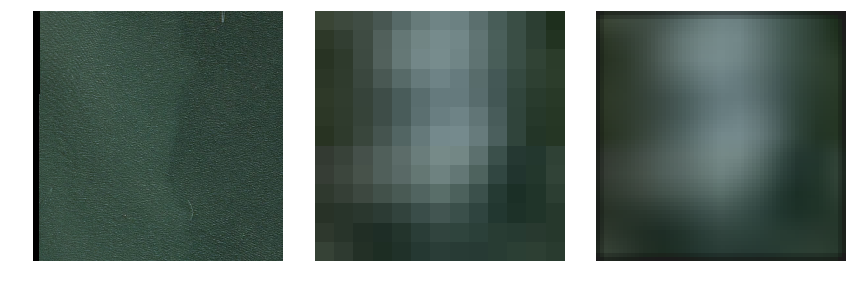

In [20]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
bd = BoxedDataset('../../data/train',(768,768),data)
bd.__len__()
idx = np.random.choice(bd.total_ships)
#idx = bd.total_ships + np.random.choice(bd.total_ships)
bd.__getitem__(idx)

In [181]:
img = imread(os.path.join('../../data/train',box_image_ids[0]))

In [127]:
img.shape

(768, 768, 3)